In [2]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
import collections
import scipy.signal
import functools
from IPython.display import HTML, display
from tqdm import tqdm
import sklearn.metrics
import hdbscan
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

seed_number_range = []     
for num in range(1):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0,5,10,15,20,25,50,100,800]

parameters_value = { "range_plasticity": ['Plasticity'], "range_after_plasticity": ['after_Plasticity'],
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}

Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)


class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
        

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)


def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle


WARNING    <timed exec>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 31 s, sys: 9.74 s, total: 40.8 s
Wall time: 48.2 s


# Figure S2-1 - A

CPU times: user 391 ms, sys: 324 ms, total: 715 ms
Wall time: 2.68 s


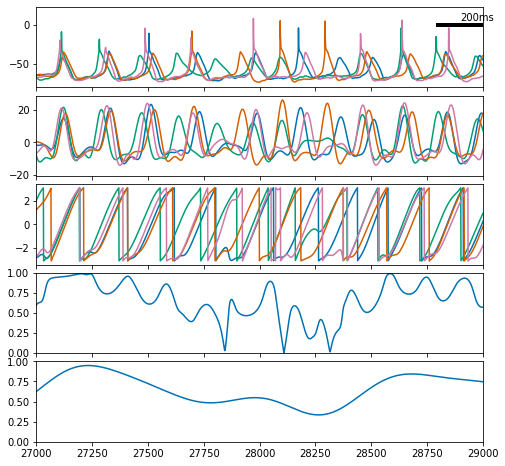

In [14]:
%%time
vs = np.array(load_io_vs(**case, n=0, f0=f0, noise_gain=1))[:4]
fs=1000
order=5
lp=4
hp=15
lpsync=2


sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
filt = scipy.signal.sosfiltfilt(sos, vs)
analytic = scipy.signal.hilbert(filt - filt.mean())
angle = np.angle(analytic)

fig, ax = plt.subplots(nrows=5, figsize=(8, 8), sharex=True, gridspec_kw=dict(hspace=.1))
ax[0].plot(vs.T)
A = 27000
B = 29000
plt.xlim(A, B)
ax[0].plot([B-200, B], [0, 0], color='black', lw=4)
ax[0].text(B-100, 5, '200ms')

ax[1].plot(filt.T)
ax[2].plot(angle.T)

synchrony = abs(np.exp(1j*np.angle(analytic)).mean(0))
ax[3].plot(synchrony.T)
sos = scipy.signal.butter(order, lpsync, 'lp', fs=fs, output='sos')
kura = scipy.signal.sosfiltfilt(sos, synchrony)

ax[4].plot(kura)
ax[3].set_ylim(0,1)
ax[4].set_ylim(0,1)

plt.savefig('svg/s2.svg')

# Figure S2-1 - B

(119999,)
(119999,)


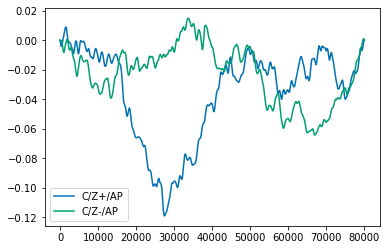

In [15]:
from scipy.signal import savgol_filter
def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle

cases = [CP.after, CN.after]
for case in cases:
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = np.unwrap(calc_phase(v, lp=4, hp=8))
    d = np.diff(phase)
    d = d.mean(0)
    d = np.cumsum(d)
    print(d.shape)
    d = savgol_filter(d, 1001, 3)
    d = d[20000:100000]
    d = d - d[0]
    #d = d - np.linspace(0, 80*2*np.pi*5.5, len(d))
    D = d[-1] - d[0]
    d = d - np.linspace(d[0], d[-1], len(d))
    d = d / (100-20)
    plt.plot(d, label=repr(case))
    # plt.plot(np.diff(d[100:-100])*1000/2/np.pi)

#plt.xlim(60000, 70000)
# plt.savefig('svg/globalphase_offset.svg')
plt.legend()


# Figure S2-1 - C

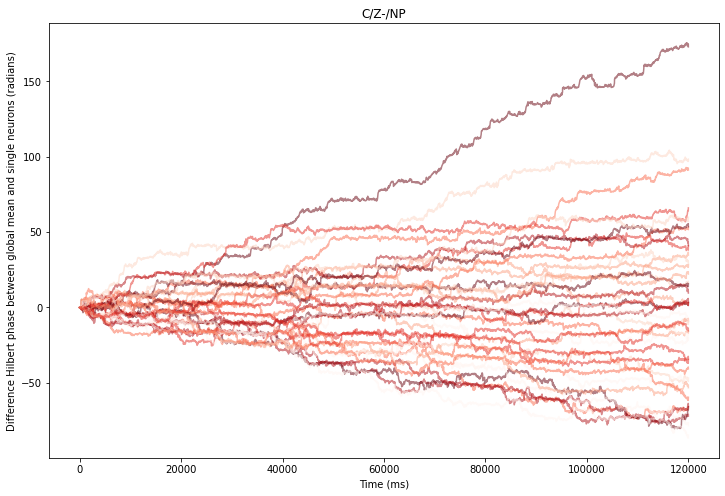

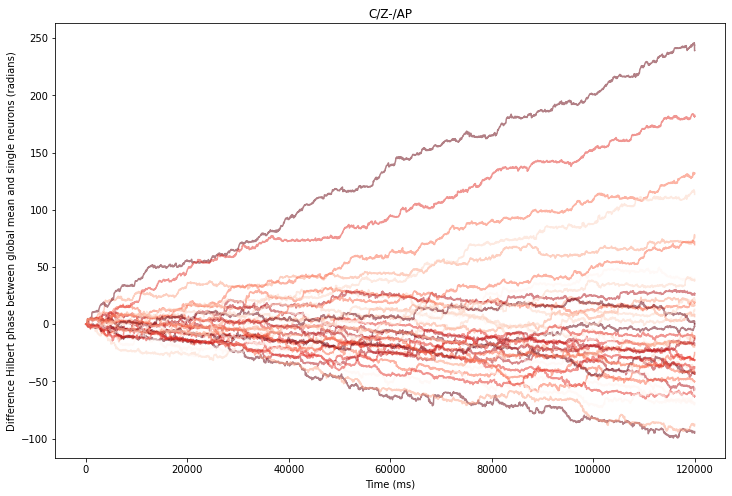

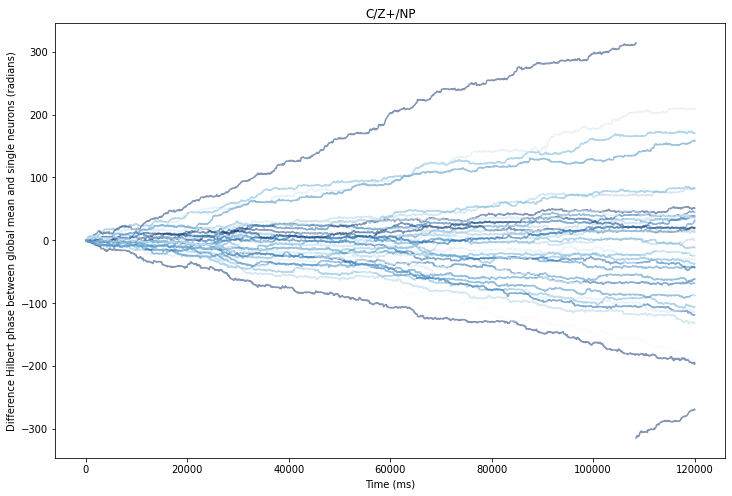

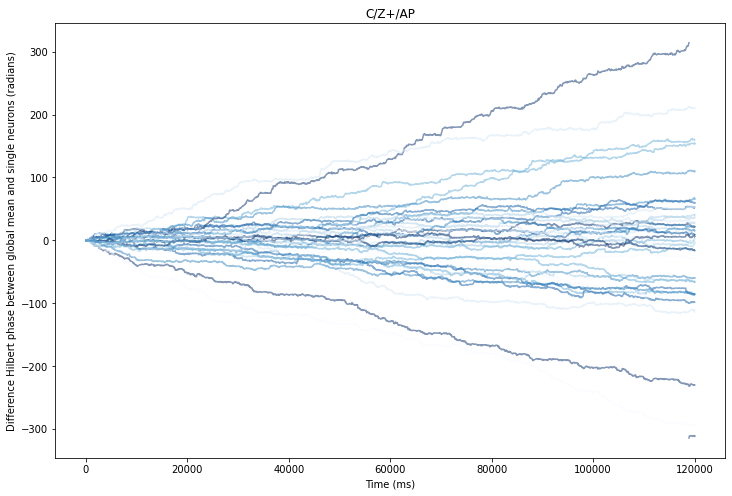

In [9]:
cases = [CN.after, CP.after]

def wrap(x, n=20):
    x = (x+n*np.pi) % (n * 2 * np.pi) - +n*np.pi
    l = []
    for xx in x:
        xx[abs(np.diff(xx, prepend=xx[0])) > n * np.pi] = float('nan')
        l.append(xx)
    return np.stack(l)




for case in cases:
    plt.figure(figsize=(12, 8))
    plt.title(str(case))
    plt.gca().set_prop_cycle(color=list(plt.get_cmap('Blues' if case['zebrin'] else 'Reds')(np.linspace(0, 1, 7))))
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = calc_phase(v)
    p = np.unwrap(phase).T
    pd = p - p.mean(1)[:,None]
    #base = np.round(p.mean(1) / (2*np.pi)).astype(int) * 2 * np.pi
    #pmean = np.unwrap(np.angle(np.exp(1j*phase).mean(0)))[:,None]
    #pmean = base + np.angle(np.exp(1j*phase).mean(0))
    #pmean = np.unwrap(pmean)
    #pmean = pmean[:,None]
    #pd = p - pmean
    for line in wrap(pd.T, 100):
        plt.plot(line, alpha=.5);
    plt.xlabel('Time (ms)')
    plt.ylabel('Difference Hilbert phase between global mean and single neurons (radians)')
    plt.savefig(f'svg/phasors_{str(case).replace("/", "_")}.svg')
    #print(p.mean(0).shape)
#plt.plot(p)

# Figure S2-1 - D

CPU times: user 25 s, sys: 500 ms, total: 25.5 s
Wall time: 25 s


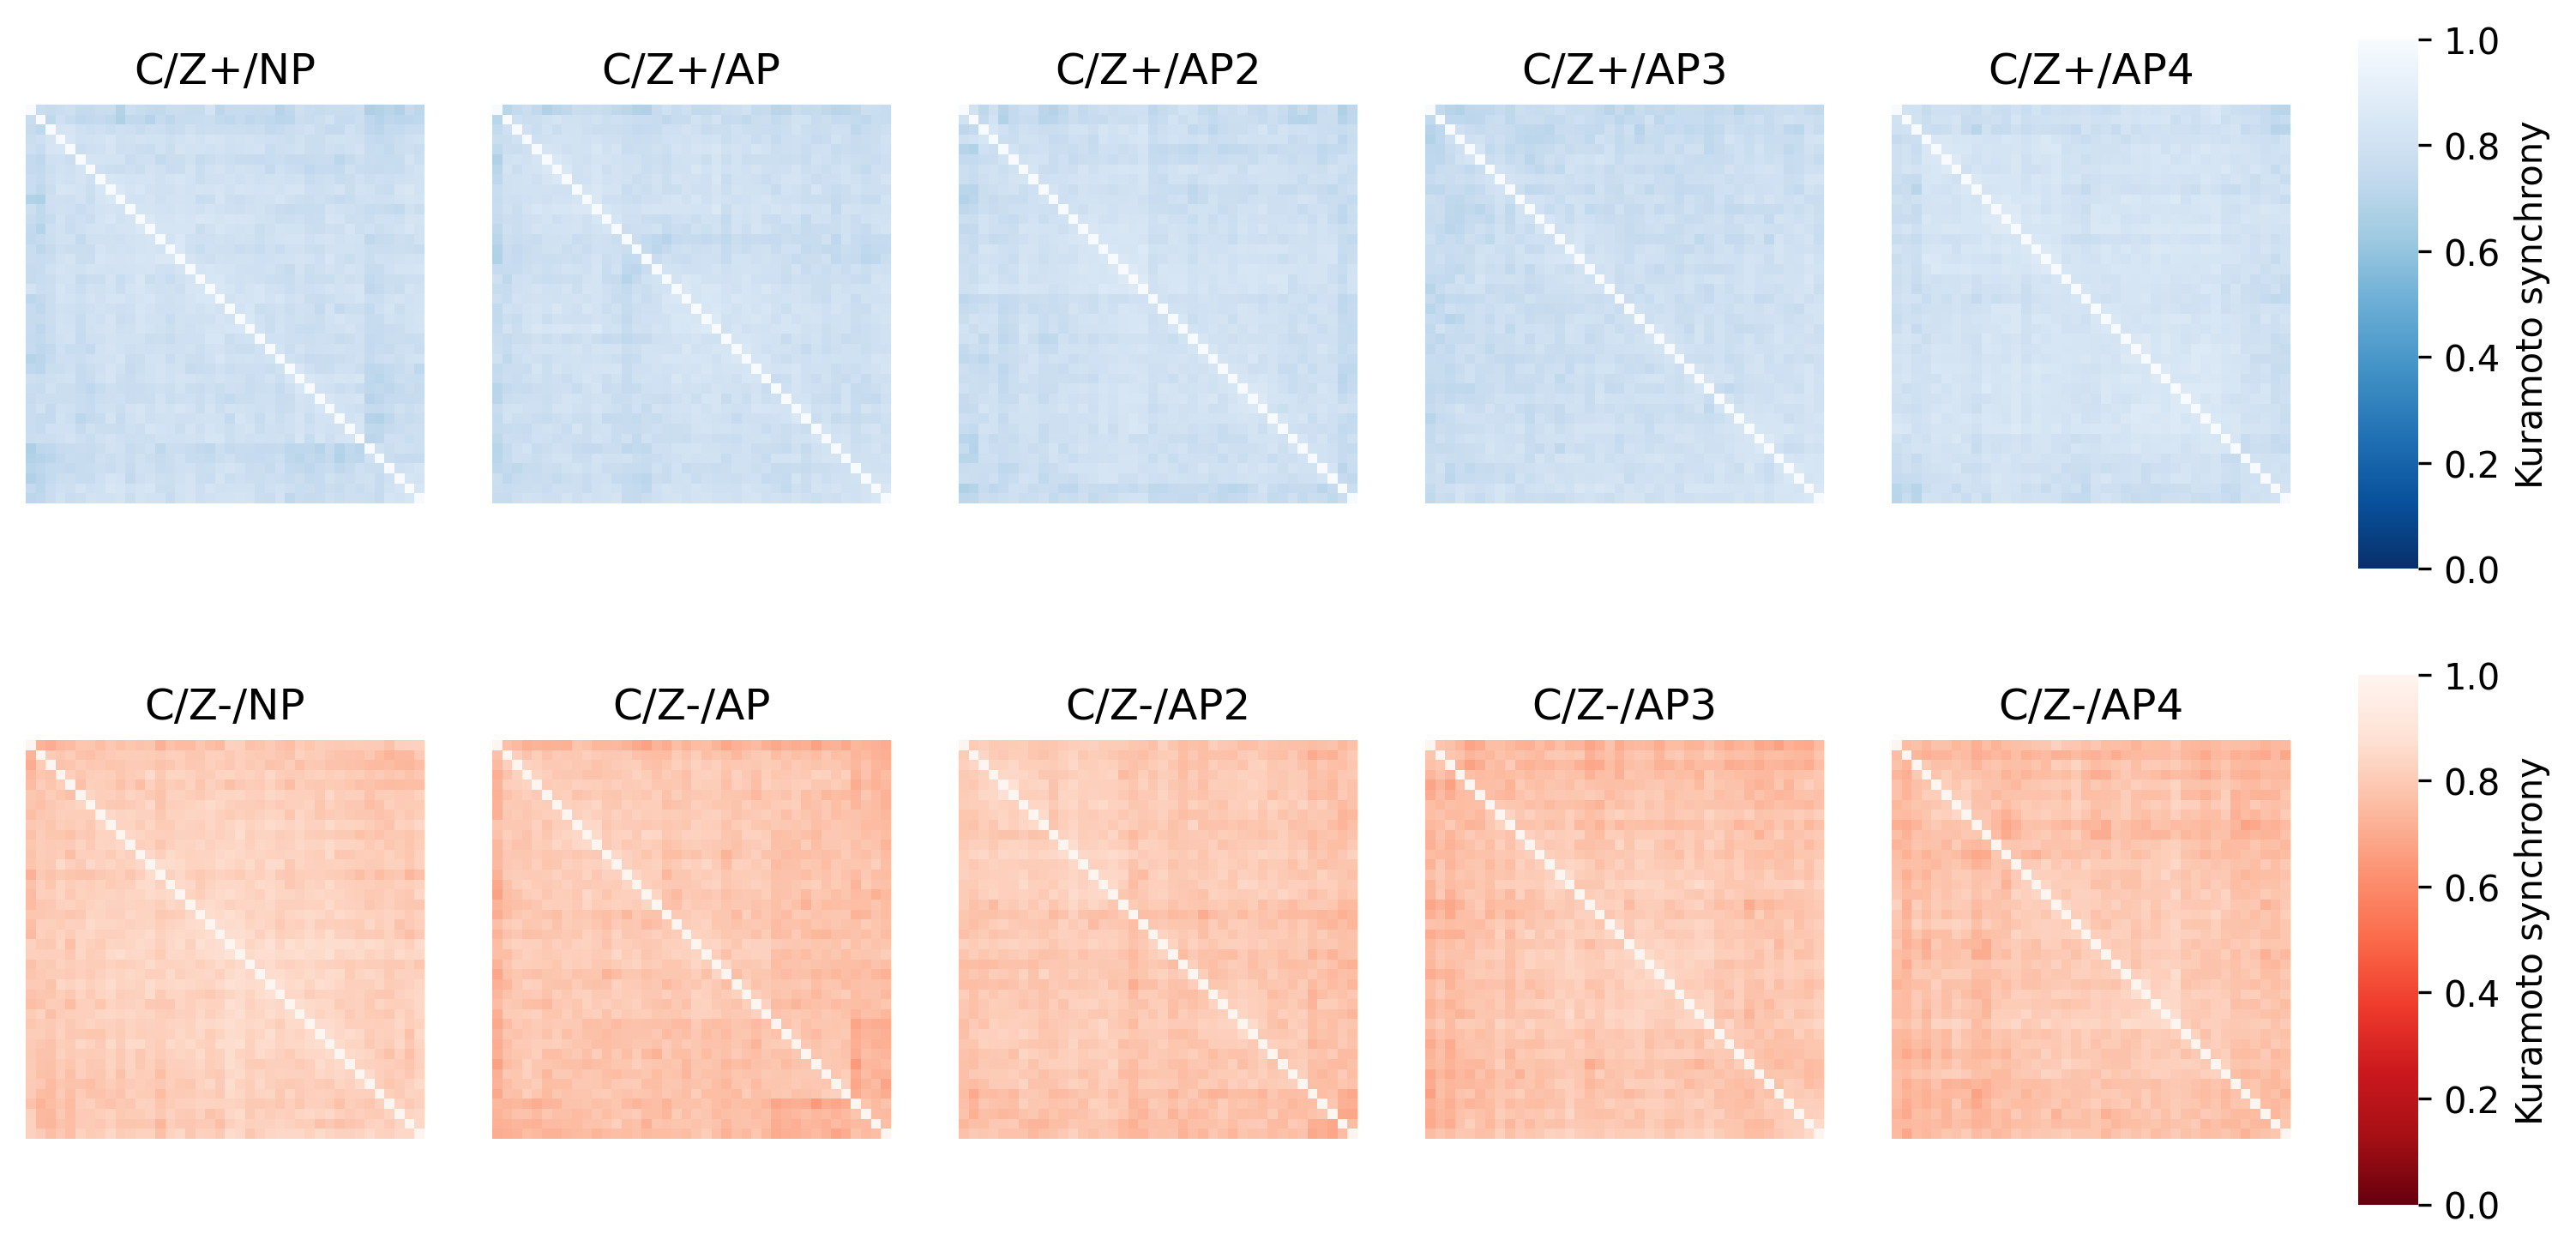

In [32]:
%%time
case1 = [
    dict(**CP.before, n=1),
    dict(**CP.after, n=1),
    dict(**CP.after, n=2),
    dict(**CP.after, n=3),
    dict(**CP.after, n=4),

    dict(**CN.before, n=1),
    dict(**CN.after, n=1),
    dict(**CN.after, n=2),
    dict(**CN.after, n=3),
    dict(**CN.after, n=4),
]

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(12, 6), dpi=300, width_ratios=[1, 1, 1, 1, 1, .15])
idxs = [None, None]
idxcases = [None, None]
idxlbl = [None,None]

for j, case in enumerate([CP, CN]):
    case = case.after
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = calc_phase(v[:,-1000:])
    metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2
    linkage_matrix = linkage(phase, method='weighted', metric=metric)
    idx = leaves_list(linkage_matrix)
    idxs[j] = idx
    idxcases[j] = case
    c = sklearn.metrics.pairwise_distances(phase, metric=metric)
    C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
    L = C.fit_predict(c)
    idxlbl[j] = L

for i in range(ax.shape[1]-1):

    for j, case in enumerate([CP, CN]):
        if i == 0:
            case = case.before
            name = str(case)
        elif i == 1:
            case = case.after
            name = str(case)
        else:
            name = str(case.after) + str(i)
            case = dict(**case, n=i)

        v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
        phase = calc_phase(v[:,-30000:])
        metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2
        if 1: # and i == 0:
            linkage_matrix = linkage(phase, method='weighted', metric=metric)
            idx = leaves_list(linkage_matrix)
            idxs[j] = idx
        else:
            idx = idxs[j]
        phase = phase[idx]
        c = sklearn.metrics.pairwise_distances(phase, metric=metric)
        C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
        L = C.fit_predict(c)
        a = ax[j, i]
        a.imshow((c), vmin=0, vmax=1, cmap='Blues' if j == 0 else 'Reds')# - np.where(np.eye(len(c)), float('nan'), 0), vmin=0., vmax=1)
        a.axis('off')

        #a.set_xticks(np.arange(len(idx)), idx)
        #a.set_yticks(np.arange(len(idx)), idx)
        a.set_title(f'{name}')

cmap = plt.get_cmap('Blues_r')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[0,-1], orientation='vertical', label='Kuramoto synchrony')
cb.outline.set_visible(False)

cmap = plt.get_cmap('Reds_r')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[1,-1], orientation='vertical', label='Kuramoto synchrony')
cb.outline.set_visible(False)

plt.savefig('svg/cluster30sf.svg')

# Figure S2-1 - E

WARNING    <ipython-input-31-2d6916769790>:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='vertical', label='Kuramoto synchrony')
 [py.warnings]
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='vertical', label='Kuramoto synchrony')



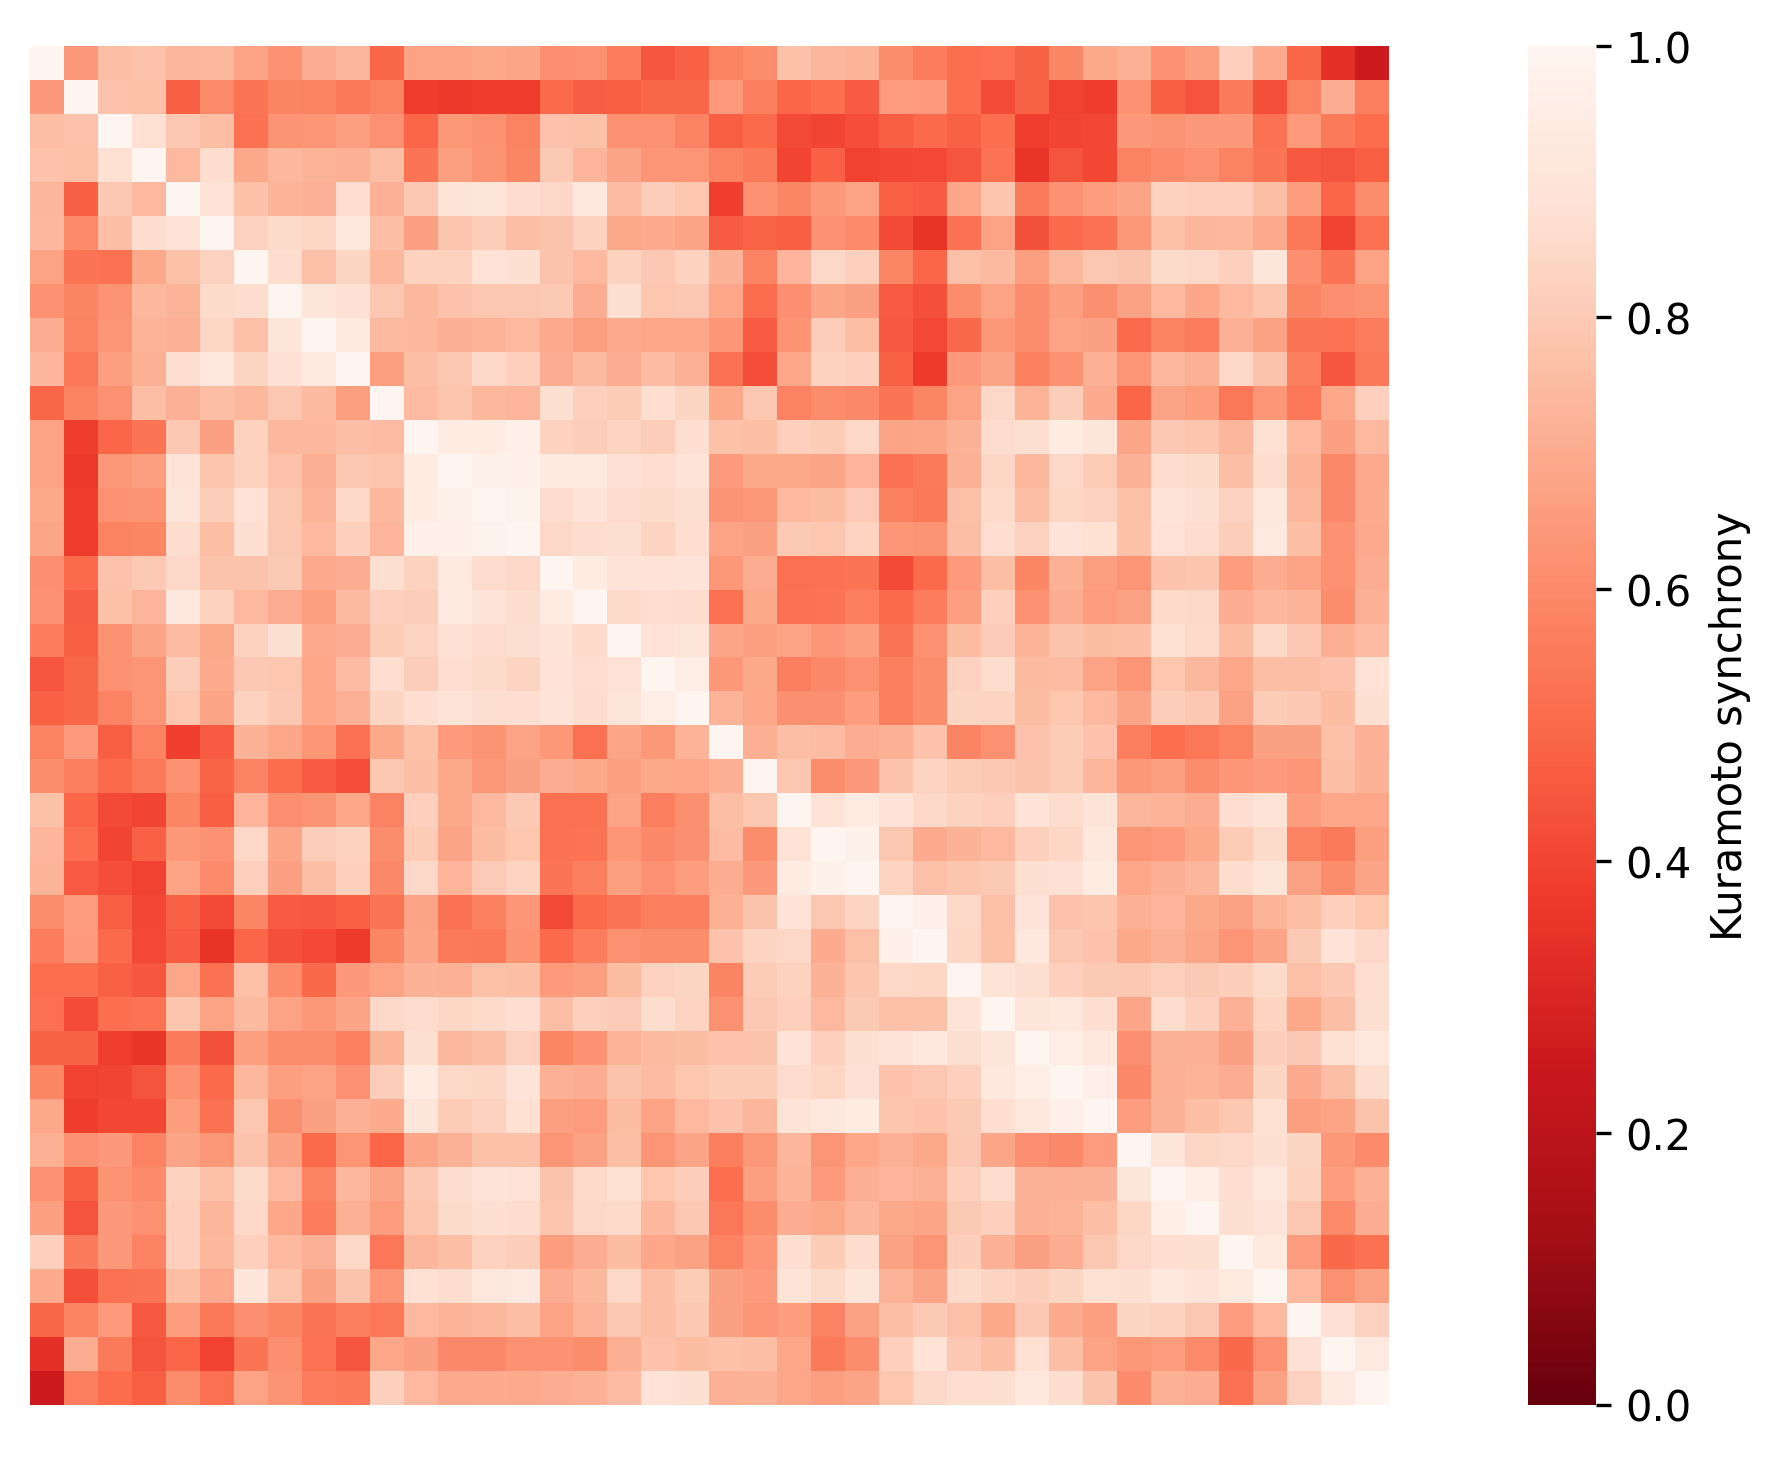

In [31]:
import sklearn.metrics
from scipy.cluster.hierarchy import linkage, leaves_list

def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle

case1 = [
    dict(**CN.after, n=1)]

fig = figure(figsize=(12, 6),dpi=300)
idxs = [None, None]
idxcases = [None, None]
idxlbl = [None,None]

for j, case in enumerate([CP, CN]):
    case = case.after
    name = str(case)
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = calc_phase(v[:,-1000:])
    metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2
    linkage_matrix = linkage(phase, method='weighted', metric=metric)
    idx = leaves_list(linkage_matrix)
    idxs[j] = idx
    idxcases[j] = case
    c = sklearn.metrics.pairwise_distances(phase, metric=metric)
    C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
    L = C.fit_predict(c)
    idxlbl[j] = L


for j, case in enumerate([CP, CN]):
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = calc_phase(v[:,-1000:])
    metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2
    if 1: # and i == 0:
        linkage_matrix = linkage(phase, method='weighted', metric=metric)
        idx = leaves_list(linkage_matrix)
        idxs[j] = idx
    else:
        idx = idxs[j]
    phase = phase[idx]
    c = sklearn.metrics.pairwise_distances(phase, metric=metric)
    C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
    L = C.fit_predict(c)
#         a = ax[j, i]
    imshow((c), vmin=0, vmax=1, cmap='Blues' if j == 0 else 'Reds')# - np.where(np.eye(len(c)), float('nan'), 0), vmin=0., vmax=1)
    axis('off')

    #a.set_xticks(np.arange(len(idx)), idx)
    #a.set_yticks(np.arange(len(idx)), idx)
#     title(f'{name}')

cmap = plt.get_cmap('Reds_r')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='vertical', label='Kuramoto synchrony')
cb.outline.set_visible(False)

# plt.savefig('svg/cluster1sf.svg')

# Figure S2-1 - F

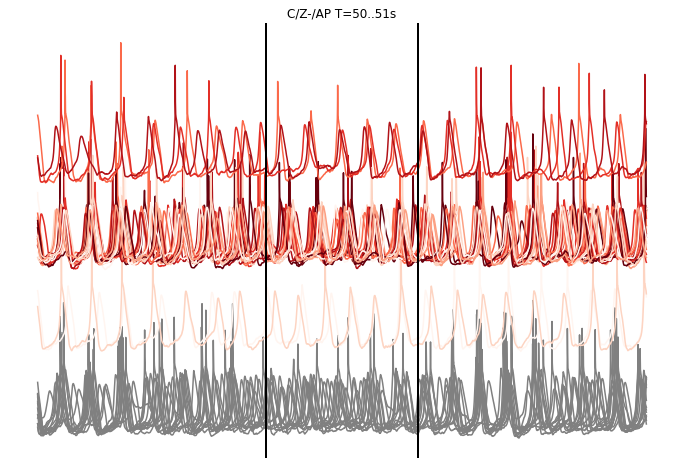

In [26]:
T = -10000

for j, case in enumerate([CN]):
    plt.figure(figsize=(12,8))
    plt.gca().set_prop_cycle(color=list(plt.get_cmap('Blues' if case['zebrin'] else 'Reds')(np.linspace(0, 1, 7))))

    case = case.after
    plt.title(str(case) + f' T={60+T//1000}..{60+T//1000+1}s')
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = calc_phase(v[:,T:T+1000])
    metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2
    linkage_matrix = linkage(phase, method='weighted', metric=metric)

    c = sklearn.metrics.pairwise_distances(phase, metric=metric)
    C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
    L = C.fit_predict(c)
    
    for cls in range(-1, L.max()+1):
        plt.plot(cls*50 + v[L == cls, T-1500:T+2500].T, color=None if cls > -1 else 'gray')
        
    plt.axvline(1500, color='black', lw=2)
    plt.axvline(2500, color='black', lw=2)
    plt.savefig(f'svg/1s_{str(case).replace("/", "_")}.svg')

    plt.axis('off')

# Figure S2-1 - G

100%|██████████| 1000/1000 [02:13<00:00,  7.46it/s]


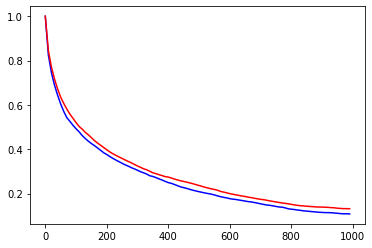

In [13]:
import tqdm 
case = CP.after

v = calc_phase(np.array(load_io_vs(**case, f0=0, noise_gain=1)))
metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2

lbl = []

delta = 10
for i in tqdm.tqdm(range(40000, 50000, delta)):
    phase = v[:,i:i+1000]
    c = sklearn.metrics.pairwise_distances(phase, metric=metric)
    C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
    L = C.fit_predict(c)
    lbl.append(L)

case = CN.after

v = calc_phase(np.array(load_io_vs(**case, f0=0, noise_gain=1)))
metric = lambda x, y: 1-abs((np.exp(1j*x)+np.exp(1j*y))).mean()/2

lbl2 = []

delta = 10
for i in tqdm.tqdm(range(40000, 50000, delta)):
    phase = v[:,i:i+1000]
    c = sklearn.metrics.pairwise_distances(phase, metric=metric)
    C = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
    L = C.fit_predict(c)
    lbl2.append(L)
    
delta = 10

window = 100
s = [[] for _ in range(window)]
s2 = [[] for _ in range(window)]
for i in tqdm.tqdm(range(len(lbl))):
    for j in range(i-window+1, i+window):
        if j < 0 or j >= len(lbl):continue
        sij = sklearn.metrics.normalized_mutual_info_score(lbl[i], lbl[j])
        s[int(abs(i-j))].append(sij)
for i in tqdm.tqdm(range(len(lbl2))):
    for j in range(i-window+1, i+window):
        if j < 0 or j >= len(lbl):continue
        sij = sklearn.metrics.normalized_mutual_info_score(lbl2[i], lbl2[j])
        s2[int(abs(i-j))].append(sij)

mu = [np.mean(x) for x in s]
mu2 = [np.mean(x) for x in s2]
t = np.arange(len(mu)) * delta
plt.plot(t, mu, color='Blue')
plt.plot(t, mu2, color='Red')
plt.savefig('svg/decay_1s.svg')